## Green prickly thing detector

The goal of the project is to build a model able to detect aerial cactus in environment.

I will be using [Aerial Cactus Identification](https://www.kaggle.com/c/aerial-cactus-identification) dataset, which is also a competition.  

In this project I will be using almost-custom-built API for image model training. API is capable to take any pretrained model and use it.

I will be working with 
- Xception
- MobileNetV2
- Custom built model without transfer learning

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageRandomCropTransformation
from datagen import generate_images

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## Data loading and analysis

In [5]:
DATA_DIR = Path('data/cactus')
TEMP_DIR = Path('temp/cactus')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
#!kaggle competitions download -c aerial-cactus-identification -p {str(DATA_DIR)}

In [7]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [8]:
df.head(10)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [9]:
df.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


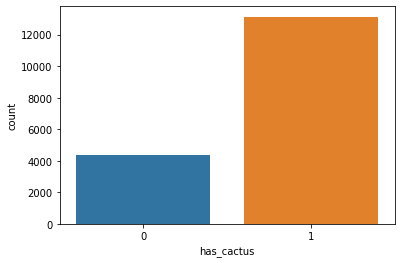

In [11]:
sns.countplot(x='has_cactus', data=df)

In [12]:
IMG_DIMS = (71, 71, 3)
df['paths'] = df['id'].apply(lambda image_id: str(DATA_DIR/'train'/image_id))

In [13]:
train_data, validation_data = train_test_split(df, test_size=0.2)

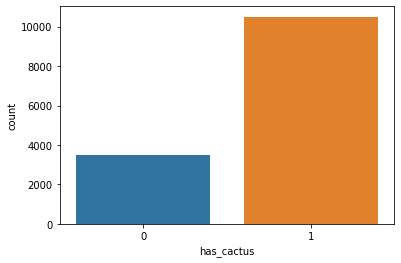

In [14]:
sns.countplot(x='has_cactus', data=train_data)

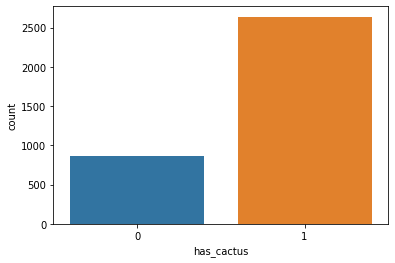

In [15]:
sns.countplot(x='has_cactus', data=validation_data)

In [16]:
test_data = pd.read_csv(DATA_DIR/'sample_submission.csv', low_memory=False)
test_data['paths'] = test_data['id'].apply(lambda image_id: str(DATA_DIR/'test'/image_id)) 

In [17]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    parallel_calls=1,
    batch_size=64,
    prefetch=1,
    preprocess_pipeline=[
        ImageParser()
    ],
)

data_container = DataContainer(
    train=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageRandomCropTransformation(IMG_DIMS, crop_adjustment=1.0)
        ],
        shuffle=True,
    )).build_from_df(train_data, 'paths', 'has_cactus'),
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageCropTransformation(IMG_DIMS),
        ],
    )).build_from_df(validation_data, 'paths', 'has_cactus'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageCropTransformation(IMG_DIMS)
        ],
    )).build_from_df(test_data, 'paths', 'has_cactus'),
)

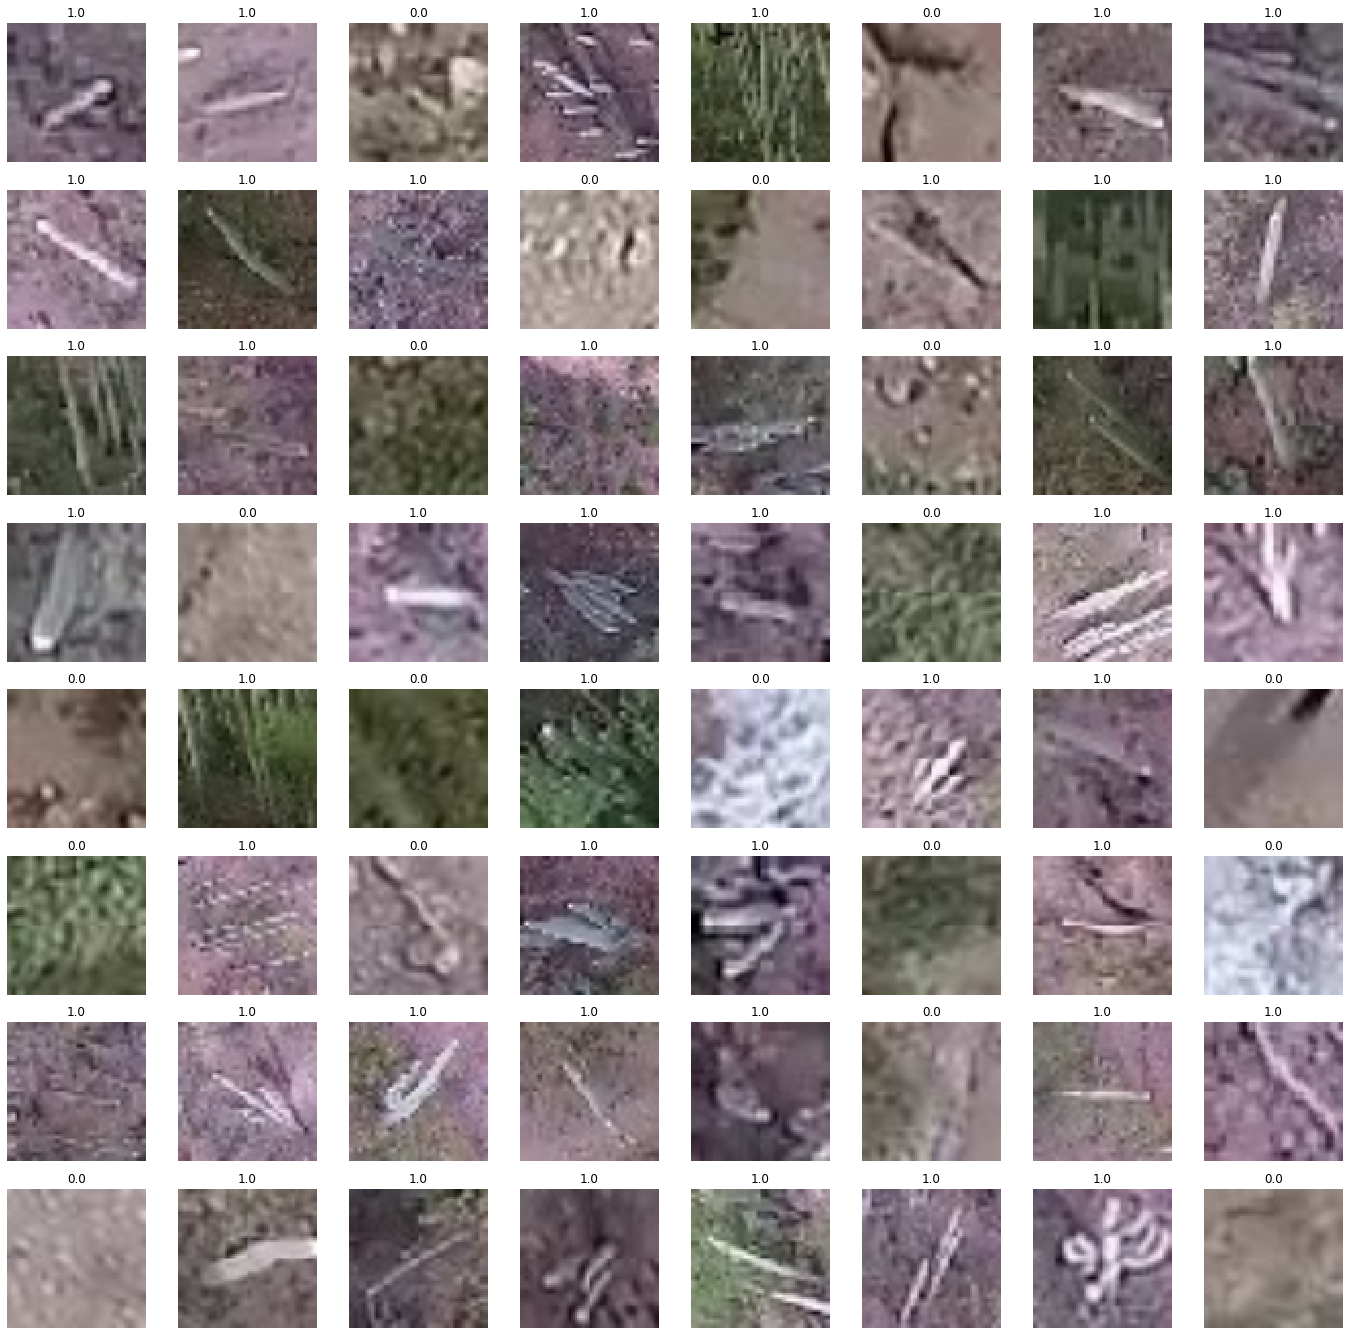

In [18]:
data_container.train.show()

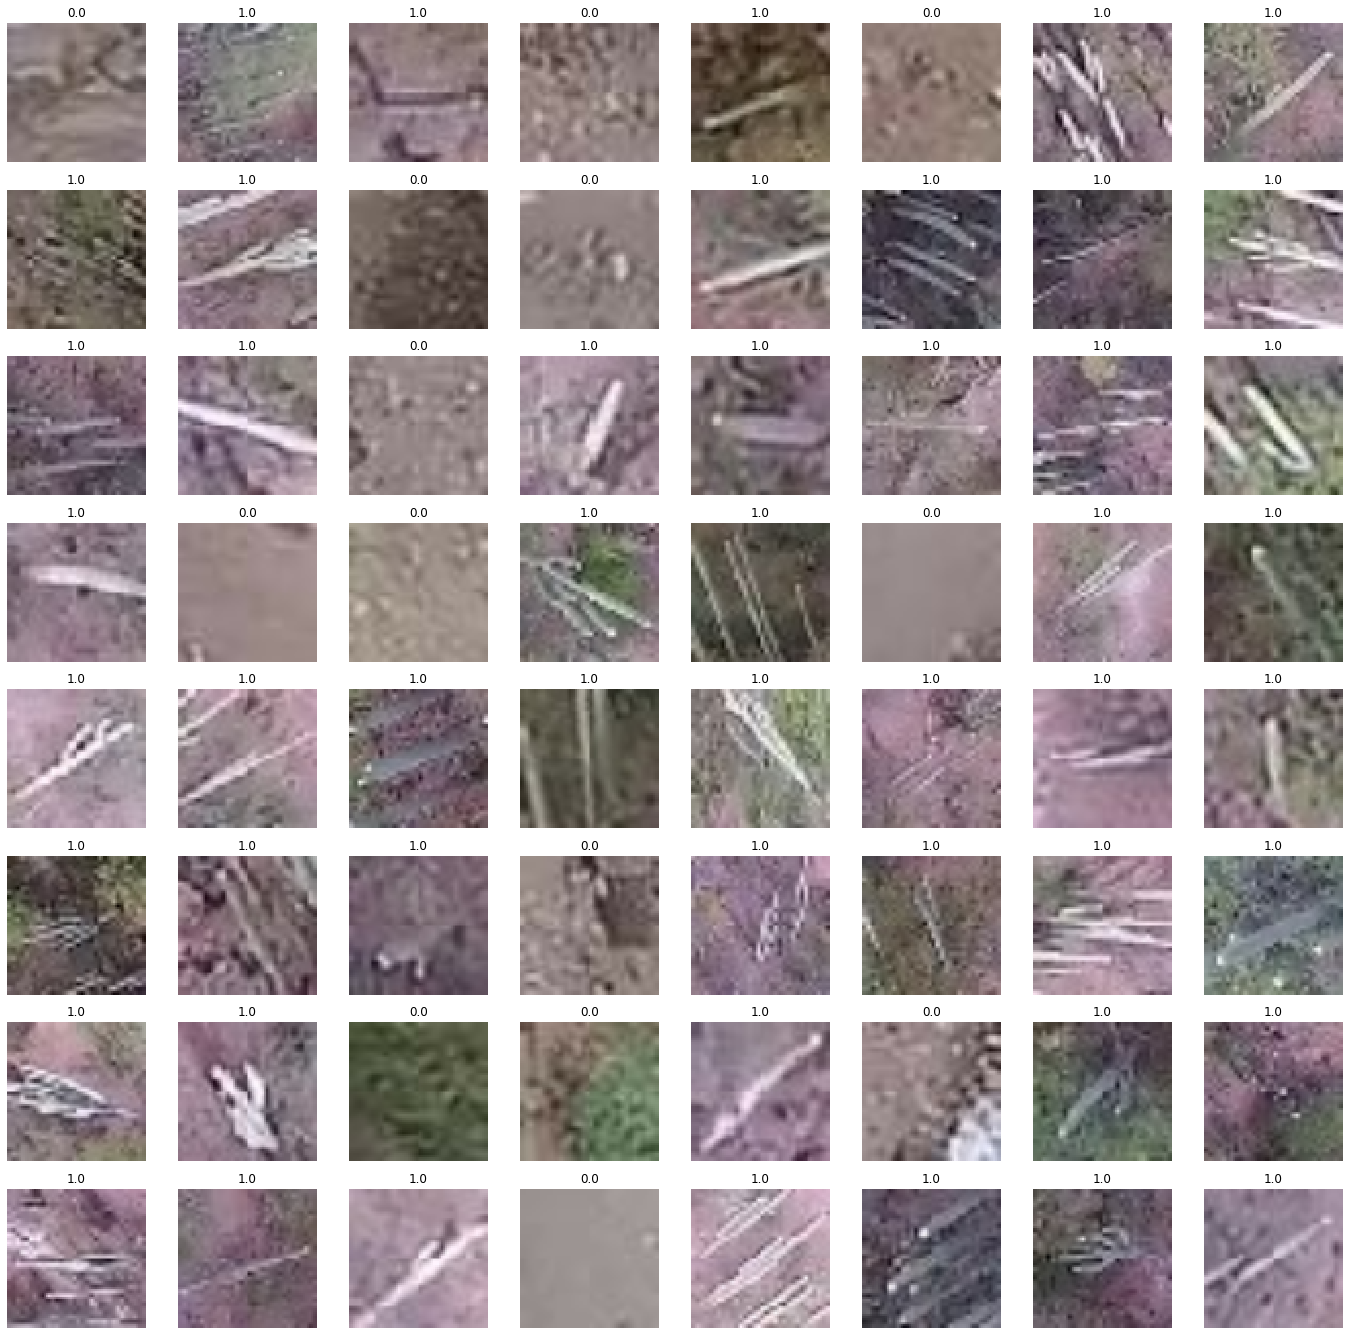

In [19]:
data_container.validation.show()

## Modeling

### Model with Xception application

In [18]:
learner = ImageLearner(
    model_path=Path('xception'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.3,
)

Existing model data path exists
Loading architecture and weights from xception
Model loaded successfully


In [19]:
learner.auto_train(
    easing_epochs=0,
    epochs=3,
    optimizer=keras.optimizers.SGD,
    lr=1e-3,
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

Starting model training
Epoch 1/3


W0905 16:45:27.194500 140055408904000 deprecation.py:323] From /home/martynas/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


219/219 [==============================] - 55s 252ms/step - loss: 0.0135 - binary_accuracy: 0.9968 - val_loss: 0.0039 - val_binary_accuracy: 0.9990
Epoch 2/3
219/219 [==============================] - 27s 123ms/step - loss: 0.0089 - binary_accuracy: 0.9976 - val_loss: 0.0032 - val_binary_accuracy: 0.9991
Epoch 3/3
219/219 [==============================] - 27s 124ms/step - loss: 0.0107 - binary_accuracy: 0.9964 - val_loss: 0.0032 - val_binary_accuracy: 0.9991
Loading weights only from xception/weights.h5
Model loaded successfully
Model training completed


In [20]:
h = pd.DataFrame(learner.history.history); h

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.013494,0.996821,0.003898,0.999000,0.001
1,0.008946,0.997607,0.003188,0.999143,0.001
2,0.010677,0.996393,0.003164,0.999143,0.001


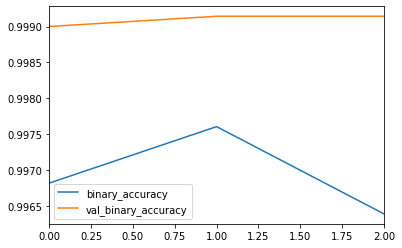

In [21]:
learner.show_history('acc', skip=0)

In [23]:
evaluation = learner.evaluate_dataset(verbose=1); evaluation

55/55 [==============================] - 2s 30ms/step - loss: 0.0032 - binary_accuracy: 0.9991


[0.0031638378965329716, 0.9991429]

### Model with MobileNetV2 application

In [82]:
learner_mn = ImageLearner(
    model_path=Path('mobile_net'),
    data=data_container,
    base_model=keras.applications.MobileNetV2,
    input_shape=IMG_DIMS,
    dropout=0.3
)

/home/martynas/.local/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Existing model data path exists
Loading architecture and weights from mobile_net
Model loaded successfully


In [83]:
learner_mn.auto_train(
    easing_epochs=5,
    epochs=15,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

Freezing all except last model layers
Training frozen model
Epoch 1/5
219/219 [==============================] - 11s 48ms/step - loss: 0.3955 - binary_accuracy: 0.8321 - val_loss: 4.8489 - val_binary_accuracy: 0.2434
Epoch 2/5
219/219 [==============================] - 6s 28ms/step - loss: 0.2881 - binary_accuracy: 0.8885 - val_loss: 6.7737 - val_binary_accuracy: 0.2429
Epoch 3/5
219/219 [==============================] - 6s 28ms/step - loss: 0.2487 - binary_accuracy: 0.9090 - val_loss: 8.7166 - val_binary_accuracy: 0.2429
Epoch 4/5
219/219 [==============================] - 6s 28ms/step - loss: 0.2257 - binary_accuracy: 0.9174 - val_loss: 6.7239 - val_binary_accuracy: 0.2429
Epoch 5/5
219/219 [==============================] - 6s 28ms/step - loss: 0.2159 - binary_accuracy: 0.9205 - val_loss: 7.5196 - val_binary_accuracy: 0.2429
Loading weights only from mobile_net/weights.h5
Model loaded successfully
Unfreezing all layers
Finished training frozen model
Starting model training
Epoch 1/

In [85]:
h_mn = pd.DataFrame(learner_mn.history.history); h_mn

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.084295,0.975321,11.344078,0.251857,0.0010
1,0.023845,0.992214,0.487790,0.926429,0.0010
2,0.016279,0.995036,1.063065,0.879000,0.0010
3,0.022875,0.993214,11.113340,0.246000,0.0010
4,0.013359,0.995536,2.899742,0.537143,0.0010
5,0.009807,0.997000,2.868709,0.622571,0.0010
6,0.001316,0.999571,0.916471,0.830143,0.0010
7,0.002169,0.999500,0.070199,0.988429,0.0003
8,0.000734,0.999857,0.058171,0.992571,0.0003
9,0.000492,0.999857,0.040538,0.992857,0.0003


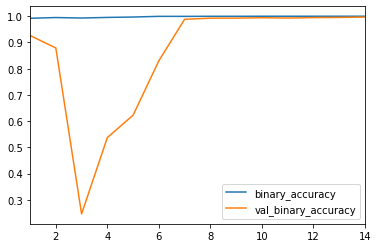

In [86]:
learner_mn.show_history('acc', skip=1)

In [87]:
learner_mn.evaluate_dataset(verbose=1)

55/55 [==============================] - 2s 29ms/step - loss: 0.0154 - binary_accuracy: 0.9969


[0.015432773974333196, 0.99685717]

## Model w/o transfer learning

Need to reload dataframe as Keras Generators expect everything to be a **str**

In [7]:
dataframe = pd.read_csv(DATA_DIR / 'train.csv', dtype={'id': str, 'has_cactus': str})

In [16]:
def build_model() -> keras.Model:
    layers = [
        keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32,3)),
        keras.layers.Activation('relu'),
        keras.layers.Conv2D(32, (3, 3)),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(64, (3, 3), padding='same'),
        keras.layers.Activation('relu'),
        keras.layers.Conv2D(64, (3, 3)),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(512),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(2, activation='sigmoid')       
    ]
    
    model = keras.Sequential(layers=layers)
    model.compile(
        keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy, 
        metrics=[keras.metrics.binary_accuracy]
    )
    
    return model

In [17]:
simple_model = build_model()

### Image preprocessing using Keras Generator

In [24]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [29]:
def create_generator(subset: str):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory='data/cactus/train',
        x_col='id',
        y_col='has_cactus',
        target_size=(32, 32),
        batch_size=32,
        subset=subset
    )

In [30]:
train_generator = create_generator(subset='training')
validation_generator = create_generator(subset='validation')

Found 14000 validated image filenames belonging to 2 classes.
Found 3500 validated image filenames belonging to 2 classes.


In [31]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALIDATION = validation_generator.n // validation_generator.batch_size

In [33]:
hsitory = simple_model.fit_generator(
    generator=generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALIDATION,
    epochs=3
)

Epoch 1/3
437/437 [==============================] - 12s 27ms/step - loss: 0.0555 - binary_accuracy: 0.9796 - val_loss: 0.0452 - val_binary_accuracy: 0.9821
Epoch 2/3
437/437 [==============================] - 12s 27ms/step - loss: 0.0482 - binary_accuracy: 0.9820 - val_loss: 0.0434 - val_binary_accuracy: 0.9834
Epoch 3/3
437/437 [==============================] - 12s 27ms/step - loss: 0.0536 - binary_accuracy: 0.9808 - val_loss: 0.0372 - val_binary_accuracy: 0.9877


In [37]:
image_batch = train_generator.next()

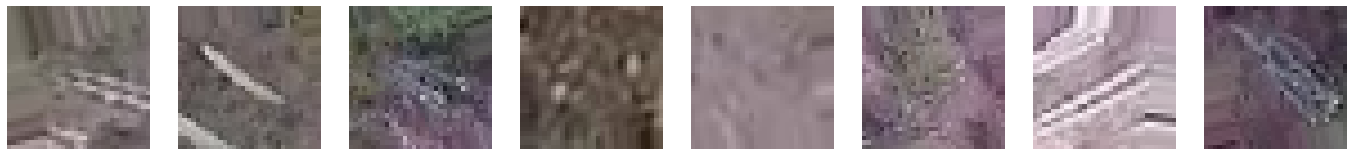

In [58]:
 _, ax = plt.subplots(1, 8, figsize=(3 * 8, 3 * 1))
i = 0
for img in image_batch[0]:
    idx = i % 8
    ax[idx].axis("off")
    ax[idx].imshow(img)
    i += 1

In [78]:
simple_model.evaluate_generator(
    generator=validation_generator,
    steps=STEP_SIZE_VALIDATION,
    verbose=1
)

109/109 [==============================] - 2s 19ms/step - loss: 0.0353 - binary_accuracy: 0.9858


[0.035256316613004365, 0.9858085]

## Final notes

### Accuracies

All models are pretty close to perfect.  
**XCeption** - 0.99914  
**MobileNetV2** - 0.99685  
**w/o transfer learning** - 0.98580  

### Model properties

**XCeption** - took quite a bit to train ~30s per epoch and saved data is considerable size. Model weights.h5 alone is ~80MB  
**MobileNetV2** - faster to train - ~20s per epoch and total size is just 9.2MB  
**w/o transfer learning** - fastest, but no so accurate

### Image preprocessing

Although it is good to have total controll over your library and image transformations I found that Keras Preprocessing API is really convenient and easy to handle. Still needs more investigation as I only had just an hour to play around with it.